In [1]:
import multiprocessing as mp
import numpy as np
from tqdm import tqdm
import subprocess
import cv2
import matplotlib.pyplot as plt
import torch
from skimage.measure import ransac
from skimage.transform import ProjectiveTransform
from skimage.feature import match


In [2]:
# Some utility functions
def computeNN(desc_ii, desc_jj):
    desc_ii, desc_jj = torch.from_numpy(desc_ii).cuda(), torch.from_numpy(desc_jj).cuda()
    d1 = (desc_ii**2).sum(1)
    d2 = (desc_jj**2).sum(1)
    distmat = (d1.unsqueeze(1) + d2.unsqueeze(0) - 2*torch.matmul(desc_ii, desc_jj.transpose(0,1))).sqrt()
    distVals, nnIdx1 = torch.topk(distmat, k=2, dim=1, largest=False)
    nnIdx1 = nnIdx1[:,0]
    _, nnIdx2 = torch.topk(distmat, k=1, dim=0, largest=False)
    nnIdx2= nnIdx2.squeeze()
    mutual_nearest = (nnIdx2[nnIdx1] == torch.arange(nnIdx1.shape[0]).cuda()).cpu().numpy()
    ratio_test = (distVals[:,0] / distVals[:,1].clamp(min=1e-10)).cpu().numpy()
    idx_sort = [np.arange(nnIdx1.shape[0]), nnIdx1.cpu().numpy()]
    return idx_sort, ratio_test, mutual_nearest

def subDescMatch(desc1, desc2, n_split):
    splitted_desc1 = np.split(desc1, n_split,1)
    splitted_desc2 = np.split(desc2, n_split,1)
    hist = np.zeros(shape=(len(desc1), len(desc2)))
    for d1, d2 in zip (splitted_desc1, splitted_desc2):
        idx_sort, ratio_test, mutual_nearest = computeNN(d1, d2)
        hist[idx_sort[0][mutual_nearest], idx_sort[1][mutual_nearest]] +=1

    return hist

def multiDescMatch(desc1, desc2, n_split, min_match):
    hists = []
    for d1, d2 in zip(desc1, desc2):
        hist = subDescMatch(d1, d2, n_split)
        hists.append(hist)
    final_matches = hists[0]>min_match
    if len(hists) >1: 
        for h in hists[1:]:
            final_matches = np.logical_and(final_matches, h>min_match)
    final_matches = np.argwhere(final_matches)
    return final_matches
def match2DMatch(matches):
    matches = [cv2.DMatch(_queryIdx=m, _trainIdx=n, _distance=-1) for m, n in matches ]
    return matches
    
def homographyAddTranslation(h, translation):
    h_t = np.eye(3)
    h_t[0, 2] = translation[1]
    h_t[1, 2] = translation[0]
    return h_t @ h

def cropImage(img,percentile=.6):
    height,width=img.shape[:2]
    h=int(percentile*height/2)
    w=int(percentile*width/2)
    return img[h:-h,w:-w]

def buildCheckerBoard(size,grid_size):
    height, width = size
    ones = np.ones((grid_size, grid_size))
    zeros = np.zeros((grid_size, grid_size))
    x1 = np.concatenate((ones, zeros), axis=1)
    x2 = np.concatenate((zeros, ones), axis=1)
    x = np.concatenate((x1, x2), axis=0)
    
    n_h = int(height/grid_size/2) +1
    n_w = int(width/grid_size/2) + 1
    board = np.tile(x,(n_h, n_w)).astype('bool')
    
    return board[:height,:width]

def stichImages(img1, img2, h, grid_size=64, inverse=False):
    dst_h, dst_w = img2.shape[:2]
    dst_shape = (dst_w * 3, dst_h * 3)
    h = homographyAddTranslation(h, (dst_h, dst_w))
    transfromed_img1 = cv2.warpPerspective(img1, h, dst_shape)
    transformed_img2 = np.pad(img2, [[dst_h, dst_h], [dst_w, dst_w]])
    mask = buildCheckerBoard(dst_shape, grid_size)
    if inverse:
        img_registeded = np.where(mask.T, transfromed_img1, transformed_img2)
    else:
        img_registeded = np.where(mask.T, transformed_img2, transfromed_img1)
    img_registeded = cropImage(img_registeded)
    plt.figure(figsize=(8, 8))
    plt.imshow(img_registeded)
    plt.show()
    return 

In [3]:

def safeDoubleDesc(img, featureExtractor1, featureExtractor2, timeout: int = 30):
    """
    Safely process a single image pair with feature extractors in a separate process.
    
    Args:
        img:  image
        featureExtractor1: First feature extractor
        featureExtractor2: Second feature extractor
        timeout: Maximum time in seconds to wait
        
    Returns:
        Tuple of (results, error_message)
        - If successful, results contains (kp1_first, desc1_first, ...) and error_message is None
        - If failed, results is None and error_message contains the error
    """
    def worker(img, featureExtractor1, featureExtractor2, return_dict):
        try:
            kp_first, desc_first = featureExtractor1.detectAndCompute(img, None)
            kp_second, desc_second = featureExtractor2.compute(img, kp_first)
            k = np.array([k.pt for k in kp_first])
            kk = np.array([k.pt for k in kp_second])
            dist = np.sum(np.abs(k[None, :, :] - kk[:, None, :]), -1)
            same = np.argwhere(dist == 0)
            keypoints = np.take(kp_first, same[:,1],0)
            desc_1st = desc_first[ same[:, 1],:]
            desc_2nd = desc_second[ same[:, 0],:]
            keypoints = cv2.KeyPoint_convert(keypoints)
            return_dict['result'] = (keypoints, desc_1st, desc_2nd)

        except Exception as e:
            return_dict['error'] = str(e)

    # Create a manager to share results between processes
    manager = mp.Manager()
    return_dict = manager.dict()
    
    # Create and start the process
    process = mp.Process(
        target=worker,
        args=(img, featureExtractor1, featureExtractor2, return_dict)
    )
    process.start()
    process.join(timeout)
    
    # Handle various failure cases
    if process.is_alive():
        process.terminate()
        process.join()
        return None, "Process timed out"
    
    if process.exitcode != 0:
        return None, f"Process crashed with exit code {process.exitcode}"
        
    if 'error' in return_dict:
        return None, return_dict['error']
        
    if 'result' in return_dict:
        return return_dict['result'], None
        
    return None, "Unknown error occurred"

class DoubleDesc(object):
  def __init__(self, featureExtractor1, featureExtractor2):
    self.featureExtractor1 = featureExtractor1
    self.featureExtractor2 = featureExtractor2

  def run(self, img):
    result, error = safeDoubleDesc(img, self.featureExtractor1, self.featureExtractor2)
    if error is None:
      kp , desc1, desc2 = result
    else:
      print("error happened in worker")
      print(error)

      return None, None, None
    cv_kp = cv2.KeyPoint_convert(kp)
 
    return cv_kp, desc1, desc2




In [4]:
img1 = cv2.imread("../misc/garden_3.ppm")
img2 = cv2.imread("../misc/garden_1.ppm")

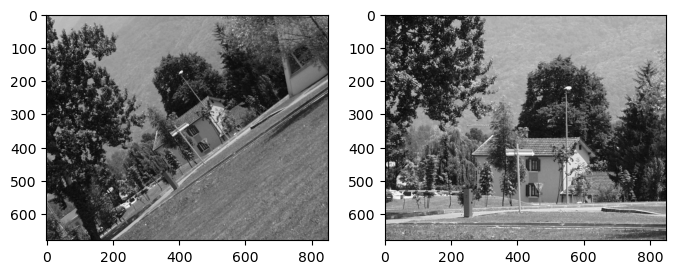

In [5]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].imshow(img1)
ax[1].imshow(img2)

In [6]:
featureExtractor1 = cv2.ORB_create()
featureExtractor2 = cv2.BRISK_create()

In [7]:
enhancedFeatureExtractor = DoubleDesc(featureExtractor1, featureExtractor2)

In [8]:
kp1, desc1, ddesc1 = enhancedFeatureExtractor.run(img1)
kp2, desc2, ddesc2 = enhancedFeatureExtractor.run(img2)

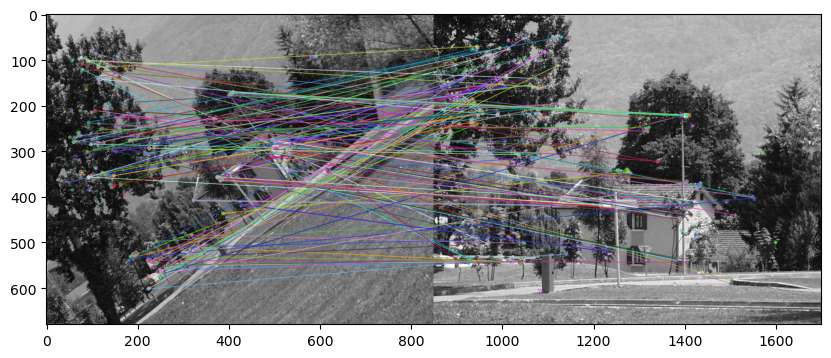

In [9]:
# Equivalent to ORB single descriptor
n_split = 1
min_match = 0

desc1 = desc1.astype("float32")
desc2 = desc2.astype("float32")



ddesc1 = ddesc1.astype("float32")
ddesc2 = ddesc2.astype("float32")

matches = multiDescMatch([desc1], [desc2], n_split, min_match)
    
cvDMatches = match2DMatch(matches)

x = cv2.drawMatches(img1, kp1, img2, kp2,cvDMatches, None)

plt.figure(figsize=(10, 5))
plt.imshow(x)

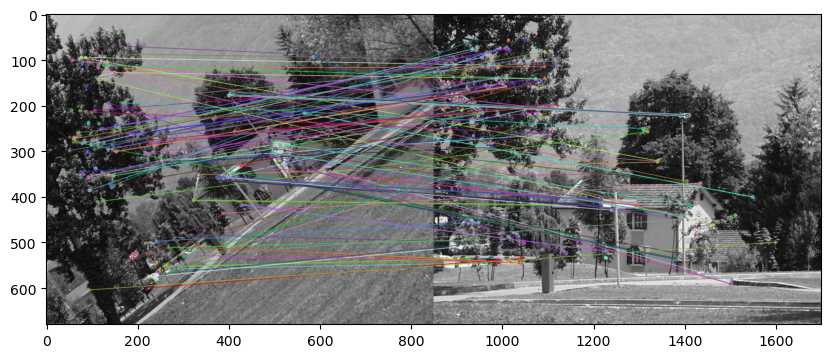

In [10]:
# Equivalent to BRISK single descriptor
n_split = 1
min_match = 0

ddesc1 = ddesc1.astype("float32")
ddesc2 = ddesc2.astype("float32")

matches = multiDescMatch([ddesc1], [ddesc2], n_split, min_match)
    
cvDMatches = match2DMatch(matches)

x = cv2.drawMatches(img1, kp1, img2, kp2,cvDMatches, None)

plt.figure(figsize=(10, 5))
plt.imshow(x)

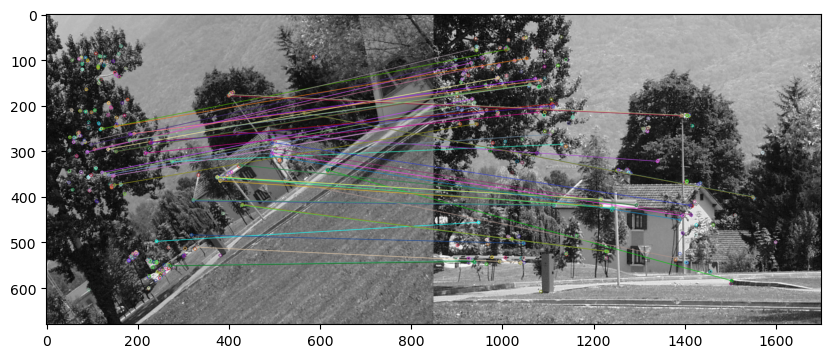

In [11]:
# Equivalent to Dual Descriptor Matching
n_split = 1
min_match = 0

ddesc1 = ddesc1.astype("float32")
ddesc2 = ddesc2.astype("float32")

matches = multiDescMatch([desc1, ddesc1], [desc2, ddesc2], n_split, min_match)
    
cvDMatches = match2DMatch(matches)

x = cv2.drawMatches(img1, kp1, img2, kp2,cvDMatches, None)

plt.figure(figsize=(10, 5))
plt.imshow(x)

In [12]:
model = ProjectiveTransform()

# Without any outlier removal

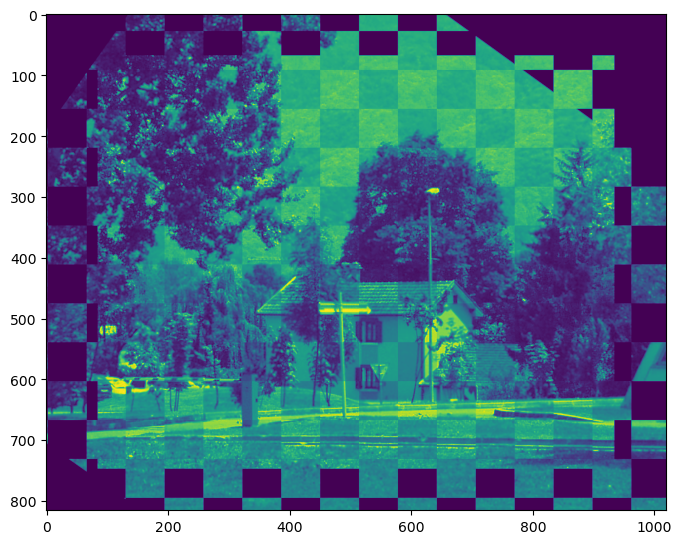

In [13]:
src_pt = np.array([a.pt for a in np.take(kp1, matches[:, 0])])
dst_pt = np.array([a.pt for a in np.take(kp2, matches[:, 1])])
model.estimate(src_pt, dst_pt)
stichImages(img1[..., 0], img2[..., 0], model.params)

# Using outlier removal

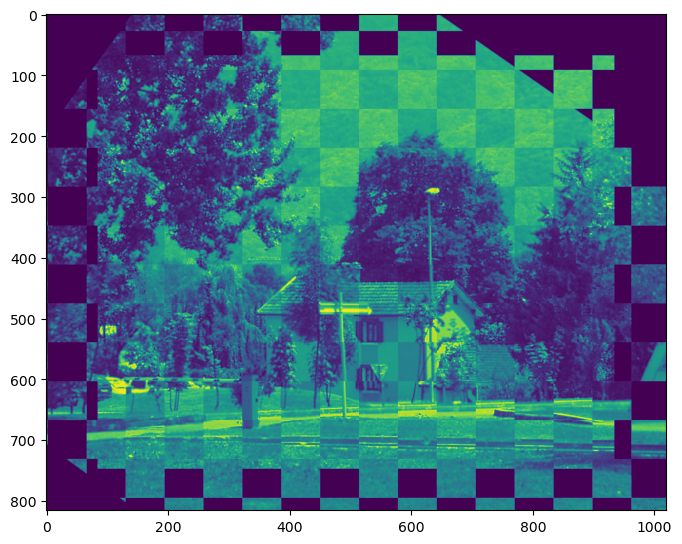

Number of all Matches:18, ROCC: 0.3157894736842105


In [14]:
src_pt = np.array([a.pt for a in np.take(kp1, matches[:, 0])])
dst_pt = np.array([a.pt for a in np.take(kp2, matches[:, 1])])
model, inliers = ransac((src_pt, dst_pt), ProjectiveTransform, 4, 1)
stichImages(img1[..., 0], img2[..., 0], model.params)
print(f"Number of all Matches:{np.sum(inliers)}, ROCC: {np.mean(inliers)}")